<a href="https://colab.research.google.com/github/FirangizSadiyeva/Covid-19/blob/main/Covid19_forecasting_LSTM_CNN_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install matplotlib-venn

import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import statsmodels.api as sm
import configparser
from datetime import timedelta
from statsmodels.tsa.api import Holt
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:

import warnings
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


In [3]:
!pip install chart_studio
!pip install plotly==4.14.3


     |████████████████████████████████| 71kB 3.4MB/s 
     |████████████████████████████████| 13.2MB 339kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [4]:
#import plotly.plotly as py
#import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot


In [5]:
corona_confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
corona_deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
corona_recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [6]:
corona_confirmed_df=corona_confirmed_df.melt(id_vars=['Province/State','Country/Region','Lat','Long'])
corona_confirmed_df=corona_confirmed_df.rename({'variable':'Date','value':'confirmed'}, axis='columns')
corona_deaths_df=corona_deaths_df.melt(id_vars=['Province/State','Country/Region','Lat','Long'])
corona_deaths_df=corona_deaths_df.rename({'variable':'Date','value':'deaths'}, axis='columns')
corona_recovered_df=corona_recovered_df.melt(id_vars=['Province/State','Country/Region','Lat','Long'])
corona_recovered_df=corona_recovered_df.rename({'variable':'Date','value':'recovered'}, axis='columns')

In [7]:
combined_df = [corona_confirmed_df, corona_deaths_df, corona_recovered_df]
combined_df = [df.set_index(['Province/State','Country/Region','Lat','Long','Date']) for df in combined_df]
combined_df=combined_df[0].join(combined_df[1:])

In [8]:
combined_df=combined_df.reset_index()

In [9]:
combined_df[['Lat', 'Long', 'confirmed', 'deaths', 'recovered']] = combined_df[['Lat', 'Long', 'confirmed', 'deaths', 'recovered']].apply(pd.to_numeric)
combined_df[['Date']] = combined_df[['Date']].apply(pd.to_datetime)
combined_df[['confirmed']] = combined_df[['confirmed']].apply(np.int64)
combined_df[['deaths']] = combined_df[['deaths']].apply(np.int64)
combined_df[['recovered']] = combined_df[['recovered']].apply(np.int64)

In [10]:
combined_df=combined_df.rename({'Province/State':'State','Country/Region':'Country'}, axis ='columns')

In [11]:
print("Size/Shape of the dataset",combined_df.shape)
print("Checking for null values",combined_df.isnull().sum())
print("Checking Data-type", combined_df.dtypes)

Size/Shape of the dataset (105651, 8)
Checking for null values State        73143
Country          0
Lat            387
Long           387
Date             0
confirmed        0
deaths           0
recovered        0
dtype: int64
Checking Data-type State                object
Country              object
Lat                 float64
Long                float64
Date         datetime64[ns]
confirmed             int64
deaths                int64
recovered             int64
dtype: object


In [12]:
combined_df.to_csv("combined.csv")

In [13]:
combined_df.drop(["State"],1,inplace=True)

In [14]:
combined_df.isnull().sum()

Country        0
Lat          387
Long         387
Date           0
confirmed      0
deaths         0
recovered      0
dtype: int64

In [15]:
#Use data until 14 days before as training
x = len(combined_df)-14

train = combined_df.iloc[:x]
test = combined_df.iloc[x:]

In [16]:
train.describe()

,Lat,Long,confirmed,deaths,recovered
count,105250.000000,105250.000000,1.056370e+05,105637.000000,1.056370e+05
mean,20.640232,23.166662,1.107786e+05,2947.345494,-7.095842e+17
std,25.134971,73.562272,8.055679e+05,17288.922211,2.457907e+18
min,-51.796300,-178.116500,0.000000e+00,0.000000,-9.223372e+18
25%,6.423800,-19.020800,4.100000e+01,0.000000,1.000000e+00
50%,21.916200,20.972650,9.180000e+02,11.000000,3.650000e+02
75%,41.143200,85.240100,1.360200e+04,247.000000,6.367000e+03
max,71.706900,178.065000,2.739046e+07,475291.000000,1.058923e+07


In [17]:
print('Min date from train set: %s' % train['Date'].min().date())
print('Max date from train set: %s' % train['Date'].max().date())

Min date from train set: 2020-01-22
Max date from train set: 2021-02-11


In [18]:
lag_size = (test['Date'].max().date() - train['Date'].max().date()).days
print('Max date from train set: %s' % train['Date'].max().date())
print('Max date from test set: %s' % test['Date'].max().date())
print('Forecast lag size', lag_size)

Max date from train set: 2021-02-11
Max date from test set: 2021-02-11
Forecast lag size 0


In [19]:
daily_confirmed = train.groupby('Date', as_index=False)['confirmed'].sum()
deaths_daily_confirmed = train.groupby(['deaths', 'Date'], as_index=False)['confirmed'].sum()
recovered_daily_confirmed = train.groupby(['recovered', 'Date'], as_index=False)['confirmed'].sum()

In [20]:
train = train[(train['Date'] >= '2020-01-23')]

In [21]:
train_gp = train.sort_values('Date').groupby(['deaths', 'recovered', 'Date'], as_index=False)
train_gp = train_gp.agg({'confirmed':['mean']})
train_gp.columns = ['deaths', 'recovered', 'Date', 'confirmed']
train_gp.head()

,deaths,recovered,Date,confirmed
0,0,-9223372036854775808,2020-01-23,0.250000
1,0,-9223372036854775808,2020-01-24,0.450000
2,0,-9223372036854775808,2020-01-25,1.600000
3,0,-9223372036854775808,2020-01-26,0.052632
4,0,-9223372036854775808,2020-01-27,0.052632


In [22]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [23]:
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('Date', axis=1), window=window, lag=lag)
series.head()

,deaths(t-29),recovered(t-29),confirmed(t-29),deaths(t-28),recovered(t-28),confirmed(t-28),deaths(t-27),recovered(t-27),confirmed(t-27),deaths(t-26),recovered(t-26),confirmed(t-26),deaths(t-25),recovered(t-25),confirmed(t-25),deaths(t-24),recovered(t-24),confirmed(t-24),deaths(t-23),recovered(t-23),confirmed(t-23),deaths(t-22),recovered(t-22),confirmed(t-22),deaths(t-21),recovered(t-21),confirmed(t-21),deaths(t-20),recovered(t-20),confirmed(t-20),deaths(t-19),recovered(t-19),confirmed(t-19),deaths(t-18),recovered(t-18),confirmed(t-18),deaths(t-17),recovered(t-17),confirmed(t-17),deaths(t-16),...,confirmed(t-12),deaths(t-11),recovered(t-11),confirmed(t-11),deaths(t-10),recovered(t-10),confirmed(t-10),deaths(t-9),recovered(t-9),confirmed(t-9),deaths(t-8),recovered(t-8),confirmed(t-8),deaths(t-7),recovered(t-7),confirmed(t-7),deaths(t-6),recovered(t-6),confirmed(t-6),deaths(t-5),recovered(t-5),confirmed(t-5),deaths(t-4),recovered(t-4),confirmed(t-4),deaths(t-3),recovered(t-3),confirmed(t-3),deaths(t-2),recovered(t-2),confirmed(t-2),deaths(t-1),recovered(t-1),confirmed(t-1),deaths(t),recovered(t),confirmed(t),deaths(t+0),recovered(t+0),confirmed(t+0)
29,0.0,-9.223372e+18,0.250000,0.0,-9.223372e+18,0.450000,0.0,-9.223372e+18,1.600000,0.0,-9.223372e+18,0.052632,0.0,-9.223372e+18,0.052632,0.0,-9.223372e+18,0.105263,0.0,-9.223372e+18,0.105263,0.0,-9.223372e+18,0.105263,0.0,-9.223372e+18,0.210526,0.0,-9.223372e+18,0.210526,0.0,-9.223372e+18,0.210526,0.0,-9.223372e+18,0.210526,0.0,-9.223372e+18,0.210526,0.0,...,0.368421,0.0,-9.223372e+18,0.368421,0.0,-9.223372e+18,0.368421,0.0,-9.223372e+18,0.368421,0.0,-9.223372e+18,0.368421,0.0,-9.223372e+18,0.368421,0.0,-9.223372e+18,0.368421,0.0,-9.223372e+18,0.368421,0.0,-9.223372e+18,0.421053,0.0,-9.223372e+18,0.421053,0.0,-9.223372e+18,0.421053,0.0,-9.223372e+18,0.421053,0,-9223372036854775808,0.473684,0,-9223372036854775808,0.473684
30,0.0,-9.223372e+18,0.450000,0.0,-9.223372e+18,1.600000,0.0,-9.223372e+18,0.052632,0.0,-9.223372e+18,0.052632,0.0,-9.223372e+18,0.105263,0.0,-9.223372e+18,0.105263,0.0,-9.223372e+18,0.105263,0.0,-9.223372e+18,0.210526,0.0,-9.223372e+18,0.210526,0.0,-9.223372e+18,0.210526,0.0,-9.223372e+18,0.210526,0.0,-9.223372e+18,0.210526,0.0,-9.223372e+18,0.263158,0.0,...,0.368421,0.0,-9.223372e+18,0.368421,0.0,-9.223372e+18,0.368421,0.0,-9.223372e+18,0.368421,0.0,-9.223372e+18,0.368421,0.0,-9.223372e+18,0.368421,0.0,-9.223372e+18,0.368421,0.0,-9.223372e+18,0.421053,0.0,-9.223372e+18,0.421053,0.0,-9.223372e+18,0.421053,0.0,-9.223372e+18,0.421053,0.0,-9.223372e+18,0.473684,0,-9223372036854775808,0.473684,0,-9223372036854775808,0.473684
31,0.0,-9.223372e+18,1.600000,0.0,-9.223372e+18,0.052632,0.0,-9.223372e+18,0.052632,0.0,-9.223372e+18,0.105263,0.0,-9.223372e+18,0.105263,0.0,-9.223372e+18,0.105263,0.0,-9.223372e+18,0.210526,0.0,-9.223372e+18,0.210526,0.0,-9.223372e+18,0.210526,0.0,-9.223372e+18,0.210526,0.0,-9.223372e+18,0.210526,0.0,-9.223372e+18,0.263158,0.0,-9.223372e+18,0.263158,0.0,...,0.368421,0.0,-9.223372e+18,0.368421,0.0,-9.223372e+18,0.368421,0.0,-9.223372e+18,0.368421,0.0,-9.223372e+18,0.368421,0.0,-9.223372e+18,0.368421,0.0,-9.223372e+18,0.421053,0.0,-9.223372e+18,0.421053,0.0,-9.223372e+18,0.421053,0.0,-9.223372e+18,0.421053,0.0,-9.223372e+18,0.473684,0.0,-9.223372e+18,0.473684,0,-9223372036854775808,0.473684,0,-9223372036854775808,0.473684
32,0.0,-9.223372e+18,0.052632,0.0,-9.223372e+18,0.052632,0.0,-9.223372e+18,0.105263,0.0,-9.223372e+18,0.105263,0.0,-9.223372e+18,0.105263,0.0,-9.223372e+18,0.210526,0.0,-9.223372e+18,0.210526,0.0,-9.223372e+18,0.210526,0.0,-9.223372e+18,0.210526,0.0,-9.223372e+18,0.210526,0.0,-9.223372e+18,0.263158,0.0,-9.223372e+18,0.263158,0.0,-9.223372e+18,0.368421,0.0,...,0.368421,0.0,-9.223372e+18,0.368421,0.0,-9.223372e+18,0.368421,0.0,-9.223372e+18,0.368421,0.0,-9.223372e+18,0.368421,0.0,-9.223372e+18,0.421053,0.0,-9.223372e+18,0.421053,0.0,-9.223372e+18,0.421053,0.0,-9.223372e+18,0.421053,0.0,-9.223372e+18,0.473684,0.0,-9.223372e+18,0.47368

In [24]:
last_deaths = 'deaths(t-%d)' % window
last_recovered = 'recovered(t-%d)' % window
series = series[(series['recovered(t)'] == series[last_recovered])]
series = series[(series['deaths(t)'] == series[last_deaths])]

In [25]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['deaths', 'recovered']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['deaths', 'recovered']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['deaths(t)', 'recovered(t)'], axis=1, inplace=True)

In [26]:
# Label
labels_col = 'confirmed(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (6988, 30)
Validation set shape (4660, 30)


,confirmed(t-29),confirmed(t-28),confirmed(t-27),confirmed(t-26),confirmed(t-25),confirmed(t-24),confirmed(t-23),confirmed(t-22),confirmed(t-21),confirmed(t-20),confirmed(t-19),confirmed(t-18),confirmed(t-17),confirmed(t-16),confirmed(t-15),confirmed(t-14),confirmed(t-13),confirmed(t-12),confirmed(t-11),confirmed(t-10),confirmed(t-9),confirmed(t-8),confirmed(t-7),confirmed(t-6),confirmed(t-5),confirmed(t-4),confirmed(t-3),confirmed(t-2),confirmed(t-1),confirmed(t)
22059,339.000000,340.000000,340.00000,343.000000,347.000000,351.000000,351.000000,352.000000,353.000000,354.000000,355.000000,358.000000,358.000000,358.0,359.000000,364.000000,367.000000,372.000000,380.000000,382.000000,382.000000,383.000000,384.000000,384.0000,384.000000,384.000000,387.0,389.000000,390.000000,390.000000
1940,14.000000,14.000000,7.00000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.0,7.000000,9.000000,11.000000,15.000000,20.000000,21.000000,21.000000,21.000000,21.000000,21.0000,21.000000,5.000000,5.0,6.000000,9.000000,9.000000
467,8.801418,9.219697,8.01626,9.420168,10.626087,9.781818,11.914286,12.767677,15.610526,11.241379,11.457831,11.012821,12.324324,10.0,10.924242,9.885246,11.092593,10.980769,11.808511,11.409091,12.142857,7.736842,8.333333,8.6875,9.266667,9.433333,9.7,8.607143,8.821429,9.333333
560,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
18552,149.500000,150.500000,150.50000,150.500000,150.500000,150.500000,151.500000,151.500000,151.500000,151.500000,151.500000,152.000000,153.000000,154.0,154.000000,154.000000,154.000000,154.000000,154.500000,154.500000,155.000000,155.500000,159.000000,159.0000,159.000000,159.000000,159.0,260.000000,260.000000,260.000000


In [27]:
epochs = 40
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [28]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               3100      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


In [29]:
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
219/219 - 1s - loss: 9068111.0000 - val_loss: 2803.5686
Epoch 2/40
219/219 - 0s - loss: 3563.2454 - val_loss: 2436.7119
Epoch 3/40
219/219 - 0s - loss: 3515.4036 - val_loss: 2183.1326
Epoch 4/40
219/219 - 0s - loss: 3755.9927 - val_loss: 2093.3042
Epoch 5/40
219/219 - 0s - loss: 2997.6672 - val_loss: 2091.5964
Epoch 6/40
219/219 - 0s - loss: 2864.6077 - val_loss: 1889.0504
Epoch 7/40
219/219 - 0s - loss: 2652.0054 - val_loss: 1755.6495
Epoch 8/40
219/219 - 0s - loss: 4623.6699 - val_loss: 1838.5065
Epoch 9/40
219/219 - 0s - loss: 5884.9326 - val_loss: 2333.7214
Epoch 10/40
219/219 - 0s - loss: 3779.4702 - val_loss: 2365.2212
Epoch 11/40
219/219 - 0s - loss: 2535.9597 - val_loss: 1722.3020
Epoch 12/40
219/219 - 0s - loss: 3697.3655 - val_loss: 5231.2500
Epoch 13/40
219/219 - 0s - loss: 3725.1816 - val_loss: 8034.5381
Epoch 14/40
219/219 - 0s - loss: 22158.6738 - val_loss: 5080.5874
Epoch 15/40
219/219 - 0s - loss: 2937.9922 - val_loss: 1949.8497
Epoch 16/40
219/219 - 0s - los

In [30]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (6988, 30, 1)
Validation set shape (4660, 30, 1)


In [31]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 29, 64)            192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 896)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                44850     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 45,093
Trainable params: 45,093
Non-trainable params: 0
_________________________________________________________________


In [32]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
219/219 - 1s - loss: 5049909.0000 - val_loss: 2346.4858
Epoch 2/40
219/219 - 1s - loss: 3475.3135 - val_loss: 2332.5017
Epoch 3/40
219/219 - 1s - loss: 3410.2969 - val_loss: 2303.2192
Epoch 4/40
219/219 - 1s - loss: 3351.8142 - val_loss: 2261.0540
Epoch 5/40
219/219 - 1s - loss: 3603.0818 - val_loss: 2275.7561
Epoch 6/40
219/219 - 1s - loss: 3475.9170 - val_loss: 2276.2927
Epoch 7/40
219/219 - 1s - loss: 4188.3398 - val_loss: 2247.1807
Epoch 8/40
219/219 - 1s - loss: 3183.4119 - val_loss: 2218.8962
Epoch 9/40
219/219 - 1s - loss: 3120.7295 - val_loss: 2190.1357
Epoch 10/40
219/219 - 1s - loss: 3470.7415 - val_loss: 2396.5435
Epoch 11/40
219/219 - 1s - loss: 3465.9788 - val_loss: 2205.5186
Epoch 12/40
219/219 - 1s - loss: 3087.0166 - val_loss: 2198.0312
Epoch 13/40
219/219 - 1s - loss: 3012.7183 - val_loss: 2223.6699
Epoch 14/40
219/219 - 1s - loss: 3013.7327 - val_loss: 2183.4226
Epoch 15/40
219/219 - 1s - loss: 2984.4600 - val_loss: 2214.1604
Epoch 16/40
219/219 - 1s - loss

In [33]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [34]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
219/219 - 4s - loss: 43223440.0000 - val_loss: 17849098.0000
Epoch 2/40
219/219 - 3s - loss: 5150693.0000 - val_loss: 33091.3438
Epoch 3/40
219/219 - 3s - loss: 17008.7676 - val_loss: 23451.0996
Epoch 4/40
219/219 - 3s - loss: 22613.6875 - val_loss: 23570.1953
Epoch 5/40
219/219 - 3s - loss: 15026.1006 - val_loss: 23128.2480
Epoch 6/40
219/219 - 3s - loss: 15980.7168 - val_loss: 23449.3203
Epoch 7/40
219/219 - 3s - loss: 2198957.2500 - val_loss: 4617236.5000
Epoch 8/40
219/219 - 3s - loss: 1836057.7500 - val_loss: 2433691.7500
Epoch 9/40
219/219 - 3s - loss: 339638.6562 - val_loss: 8868.8604
Epoch 10/40
219/219 - 3s - loss: 5027.5015 - val_loss: 3232.6248
Epoch 11/40
219/219 - 3s - loss: 4116.5928 - val_loss: 3236.7063
Epoch 12/40
219/219 - 3s - loss: 4090.6860 - val_loss: 3022.6462
Epoch 13/40
219/219 - 3s - loss: 36415.8242 - val_loss: 6435.5034
Epoch 14/40
219/219 - 3s - loss: 611549.8125 - val_loss: 2604.0471
Epoch 15/40
219/219 - 3s - loss: 3452.8154 - val_loss: 2591.75

In [35]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (6988, 2, 15, 1)
Validation set shape (4660, 2, 15, 1)


In [36]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=adam)

In [37]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)


Epoch 1/40
219/219 - 3s - loss: 1092471.7500 - val_loss: 15489.2549
Epoch 2/40
219/219 - 1s - loss: 20286.2871 - val_loss: 1818.4232
Epoch 3/40
219/219 - 1s - loss: 102786.4141 - val_loss: 1825.3315
Epoch 4/40
219/219 - 1s - loss: 3600.6311 - val_loss: 1932.3116
Epoch 5/40
219/219 - 1s - loss: 3439.9690 - val_loss: 8304.4512
Epoch 6/40
219/219 - 1s - loss: 7661.9731 - val_loss: 1834.1249
Epoch 7/40
219/219 - 1s - loss: 2851.7903 - val_loss: 2116.2971
Epoch 8/40
219/219 - 1s - loss: 2680.7324 - val_loss: 1897.8755
Epoch 9/40
219/219 - 1s - loss: 2717.7908 - val_loss: 1982.8284
Epoch 10/40
219/219 - 1s - loss: 5020.6675 - val_loss: 2354.3838
Epoch 11/40
219/219 - 1s - loss: 190922.0156 - val_loss: 2095.8201
Epoch 12/40
219/219 - 1s - loss: 2722.7261 - val_loss: 1804.5212
Epoch 13/40
219/219 - 1s - loss: 2861.0825 - val_loss: 1886.1560
Epoch 14/40
219/219 - 1s - loss: 102877.6797 - val_loss: 1270018.3750
Epoch 15/40
219/219 - 1s - loss: 242928.1562 - val_loss: 1596574.7500
Epoch 16/40
219

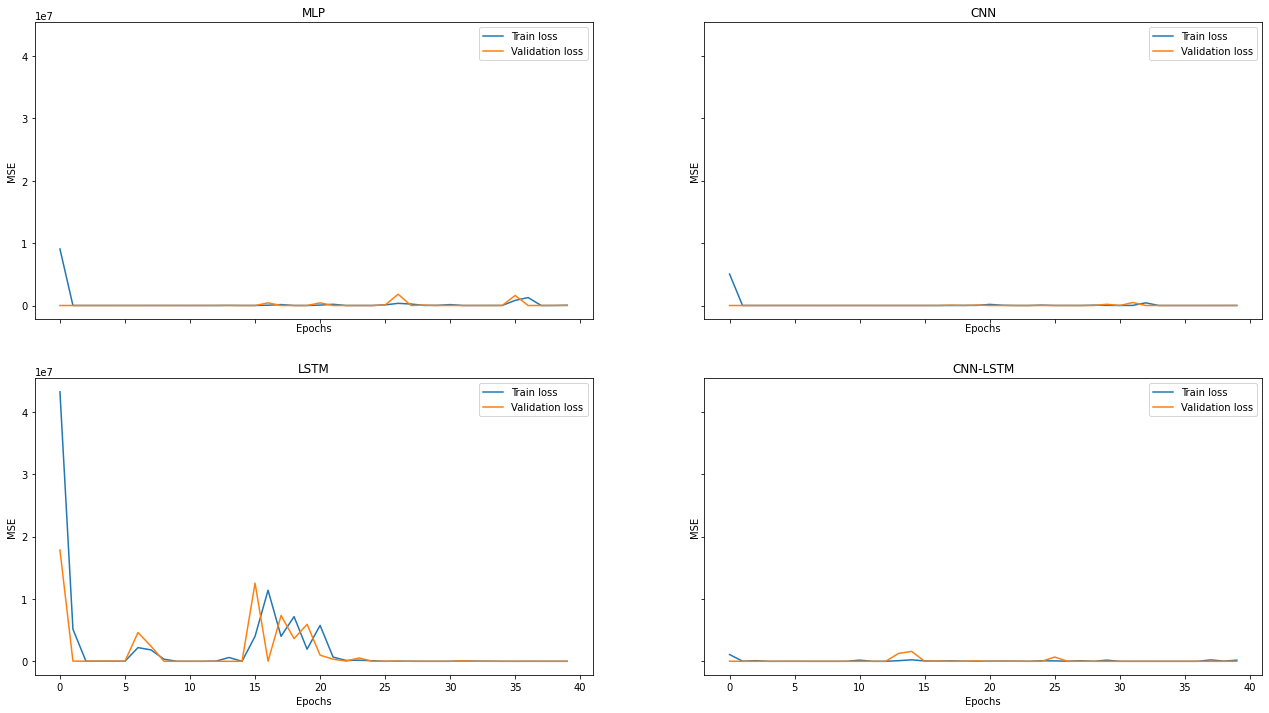

In [38]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(lstm_history.history['loss'], label='Train loss')
ax3.plot(lstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')

ax4.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax4.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('CNN-LSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('MSE')

plt.show()

MLP on train and validation

In [39]:
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, mlp_valid_pred)))

Train rmse: 35.637782257237454
Validation rmse: 33.96747439769939


CNN on train and validation

In [40]:
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

Train rmse: 59.88641230674003
Validation rmse: 57.011920803037285


LSTM on train and validation

In [41]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

Train rmse: 67.47420383221841
Validation rmse: 57.011920803037285


CNN-LSTM on train and validation

In [42]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred)))

Train rmse: 95.63887114493399
Validation rmse: 98.59520021289381


In [43]:
#https://www.kaggle.com/dimitreoliveira/deep-learning-for-time-series-forecasting/notebook